In [141]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__


('2.15.0', '1.25.2')

In [2]:
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [211]:
# from zipfile import ZipFile
# with ZipFile('/content/gdrive/MyDrive/data/CV_Signature_Dataset.zip', 'r') as zObject:
#       zObject.extractall(
#               path="/content/gdrive/MyDrive/data/CV_Signature_Dataset")

In [142]:
folders=os.listdir('/content/gdrive/MyDrive/CV_Signature_Dataset')
folders

['personA', 'personB', 'personC', 'personD', 'personE']

In [43]:
import os
import pandas as pd
import cv2

dataset_root = "/content/gdrive/MyDrive/CV_Signature_Dataset"
folders = ['personA', 'personB', 'personC', 'personD', 'personE']
def get_labels(folder_name):
    labels_train= []
    images_train = []
    labels_test = []
    images_test = []
    for folder in folders:
        if folder==folder_name:
                # Read train images and labels
                train_images_folder_path = os.path.join(dataset_root, folder, "Train")
                for file in os.listdir(train_images_folder_path):
                    if file.endswith('.png'):
                        img = cv2.imread(os.path.join(train_images_folder_path, file))
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img=cv2.resize(img,(224,224))
                        images_train.append(img)
                    else:
                        labels_trn=pd.read_csv(os.path.join(train_images_folder_path, file))
                        labels_train.append(labels_trn)
                # Read test images and labels
                test_images_folder_path = os.path.join(dataset_root, folder, "Test")
                for file in os.listdir(test_images_folder_path):
                    if file.endswith('.png'):
                        img = cv2.imread(os.path.join(test_images_folder_path, file))
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img=cv2.resize(img,(224,224))
                        images_test.append(img)
                    else:
                        labels_tst=pd.read_csv(os.path.join(test_images_folder_path, file))
                        labels_test.append(labels_tst)
    return images_train, labels_train, images_test, labels_test



In [182]:
import os
import pandas as pd

def read_labels_from_csv(csv_file):
    labels = {}
    df = pd.read_csv(csv_file)
    for index, row in df.iterrows():
        labels[row['image_name']] = row['label']
    return labels

def process_person_folder(dataset_root, person_folder,split_folder):
    images_folder_urls = []
    labels = []


    split_path = os.path.join(dataset_root, person_folder, split_folder)

    label_csv_filename = f"{person_folder}_SigVerification{split_folder}Labels.csv"
    label_csv_path = os.path.join(split_path, label_csv_filename)

    label_dict = read_labels_from_csv(label_csv_path)

    images_folder = os.path.join(split_path)
    if os.path.exists(images_folder):
        for filename in os.listdir(images_folder):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(images_folder, filename)
                if filename in label_dict:
                    images_folder_urls.append(image_path)
                    labels.append(label_dict[filename])

    return images_folder_urls, labels

def process_all_data(dataset_root, folders,split_folder):
    all_images_dict = {}

    for person_folder in folders:
        person_folder_path = os.path.join(dataset_root, person_folder)
        if os.path.isdir(person_folder_path):
            images_folder_urls, labels = process_person_folder(dataset_root, person_folder,split_folder)
            all_images_dict[person_folder] = (images_folder_urls, labels)

    return all_images_dict

dataset_root = "/content/gdrive/MyDrive/CV_Signature_Dataset"
folders = ['personA', 'personB', 'personC', 'personD', 'personE']

all_images_dict = process_all_data(dataset_root, folders,'Train')

transformed_images_dict = {}

for person_folder, (images_folder_urls, labels) in all_images_dict.items():
    full_image_paths = [os.path.join(dataset_root, path) for path in images_folder_urls]
    transformed_images_dict[person_folder] = (full_image_paths, labels)

transformed_images_dict
num_persons = len(transformed_images_dict)
print(f"Number of person folders: {num_persons}")


Number of person folders: 5


In [183]:
test = process_all_data(dataset_root, folders,'Test')

test_dict = {}

for person_folder, (images_folder_urls, labels) in test.items():
    full_image_paths = [os.path.join(dataset_root, path) for path in images_folder_urls]
    test_dict[person_folder] = (full_image_paths, labels)

test_dict
num_persons = len(test_dict)
print(f"Number of person folders: {num_persons}")

Number of person folders: 5


In [209]:
def generate_triplets(all_images_dict, num_triplets=1000):
    """
    Generate anchor, positive, and negative triplets for training a Siamese network.

    Args:
        all_images_dict (dict): Dictionary containing all images and labels for each person.
        num_triplets (int): Number of triplets to generate (default is 1000).

    Returns:
        anchor_triplets (list): List of anchor images for triplets.
        positive_triplets (list): List of positive images for triplets (same class as anchor).
        negative_triplets (list): List of negative images for triplets (different class from anchor).
    """
    anchor_triplets = []
    positive_triplets = []
    negative_triplets = []

    persons = list(all_images_dict.keys())

    for _ in range(num_triplets):
        # Randomly select a person as anchor
        anchor_person = np.random.choice(persons)
        anchor_images, anchor_labels = all_images_dict[anchor_person]

        # Randomly select an anchor image and its label
        anchor_index = np.random.randint(0, len(anchor_images))
        anchor_image = anchor_images[anchor_index]
        anchor_label = anchor_labels[anchor_index]

        # Select a positive image with the same label as the anchor
        positive_indices = np.where(np.array(anchor_labels) == anchor_label)[0]
        positive_index = np.random.choice(positive_indices)
        positive_image = anchor_images[positive_index]

        # Select a negative person with a different label from the anchor person
        negative_persons = [p for p in persons if p != anchor_person]
        negative_person = np.random.choice(negative_persons)
        negative_images, negative_labels = all_images_dict[negative_person]

        # Randomly select a negative image and its label
        negative_index = np.random.randint(0, len(negative_images))
        negative_image = negative_images[negative_index]

        # Append to triplet lists
        anchor_triplets.append(anchor_image)
        positive_triplets.append(positive_image)
        negative_triplets.append(negative_image)

    return anchor_triplets, positive_triplets, negative_triplets


# Generate triplets using the dictionary
anchors, positives, negatives = generate_triplets(transformed_images_dict, num_triplets=1000)


In [185]:
from sklearn.model_selection import train_test_split
def split_triplets(anchors,
                   positives,
                   negatives,
                   validation_split=0.2):

    triplets = list(zip(anchors, positives, negatives))

    train_triplets, val_triplets = train_test_split(triplets,
                                                    test_size=validation_split,
                                                    random_state=42)

    return train_triplets, val_triplets

In [186]:
train_triplets, val_triplets = split_triplets(anchors,
                                              positives,
                                              negatives)
len(train_triplets), len(val_triplets)

(800, 200)

In [187]:
def read_image(img):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    return img

In [188]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

In [201]:
#train_triplets

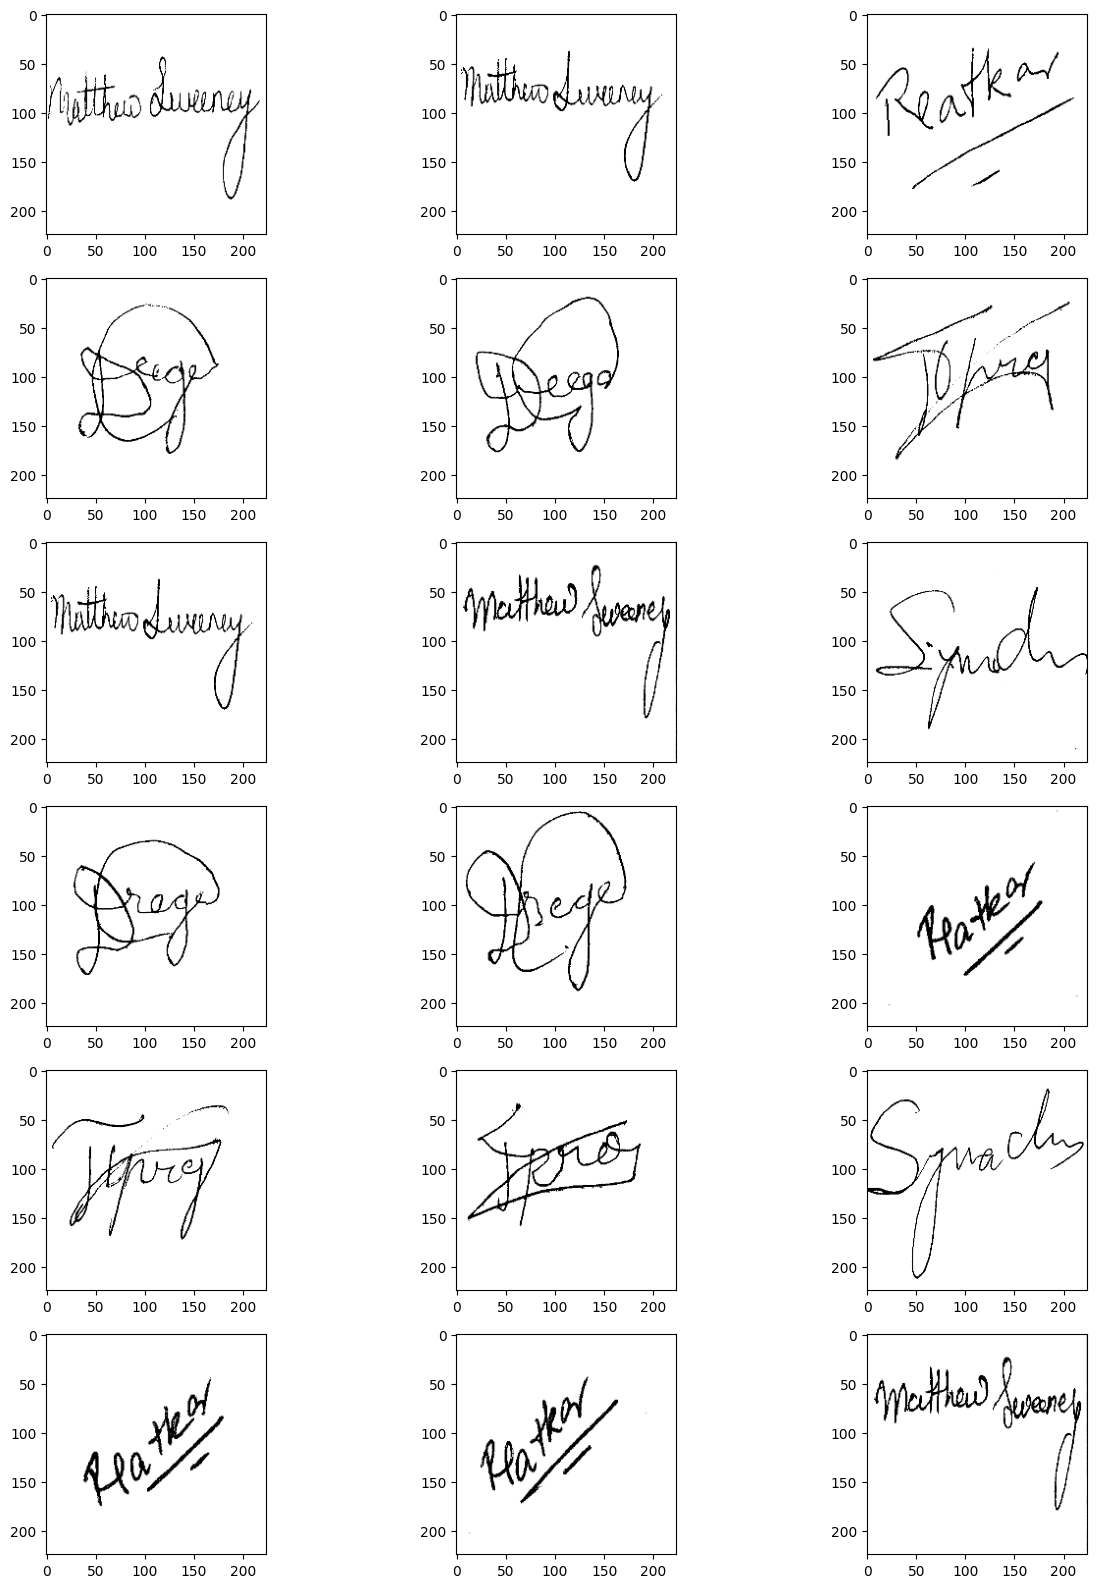

In [190]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplets, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

# **Creating The Model**

In [191]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [195]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [196]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (224, 224, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Anchor_Input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Positive_Input (InputLayer  [(None, 224, 224, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Negative_Input (InputLayer  [(None, 224, 224, 3)]        0         []                            
 )                                                                                                
                                                                                    

In [197]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]


In [198]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [199]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(val_triplets, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [200]:
save_all = False
epochs = 10
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()

    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplets, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]

    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 63 sec)
Loss on train    = 0.32010
3/3 [==============================] - 3s 384ms/step
Accuracy on test = 1.00000

EPOCH: 2 	 (Epoch done in 35 sec)
Loss on train    = 0.01046
3/3 [==============================] - 1s 406ms/step
Accuracy on test = 1.00000

EPOCH: 3 	 (Epoch done in 39 sec)
Loss on train    = 0.00046
3/3 [==============================] - 1s 397ms/step
Accuracy on test = 1.00000

EPOCH: 4 	 (Epoch done in 35 sec)
Loss on train    = 0.00006
3/3 [==============================] - 1s 395ms/step
Accuracy on test = 1.00000

EPOCH: 5 	 (Epoch done in 36 sec)
Loss on train    = 0.00000
3/3 [==============================] - 1s 406ms/step
Accuracy on test = 1.00000

EPOCH: 6 	 (Epoch done in 35 sec)
Loss on train    = 0.00000
3/3 [==============================] - 1s 347ms/step
Accuracy on test = 1.00000

EPOCH: 7 	 (Epoch done in 35 sec)
Loss on train    = 0.00001
3/3 [==============================] - 1s 402ms/step
Accuracy on test = 1.00000

EPOCH

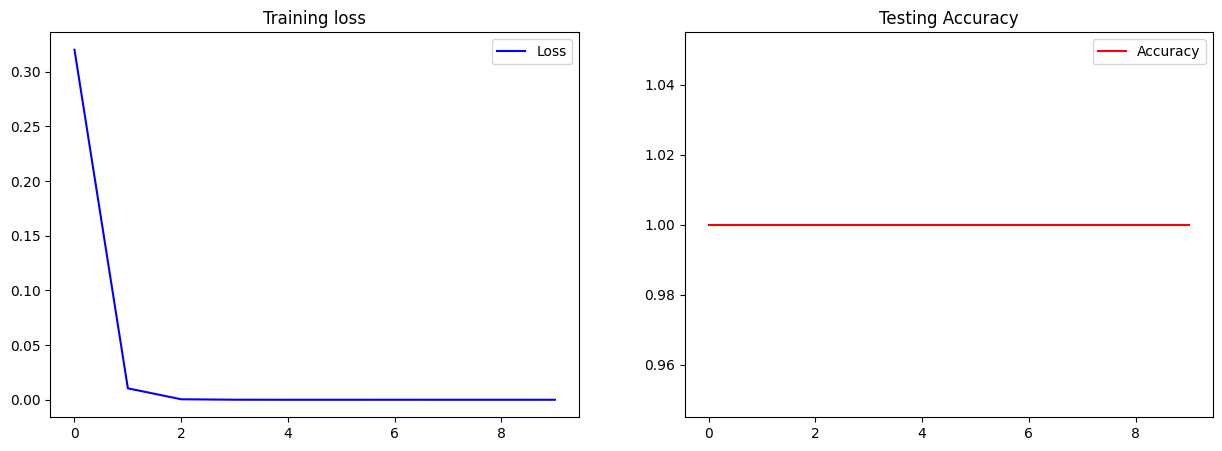

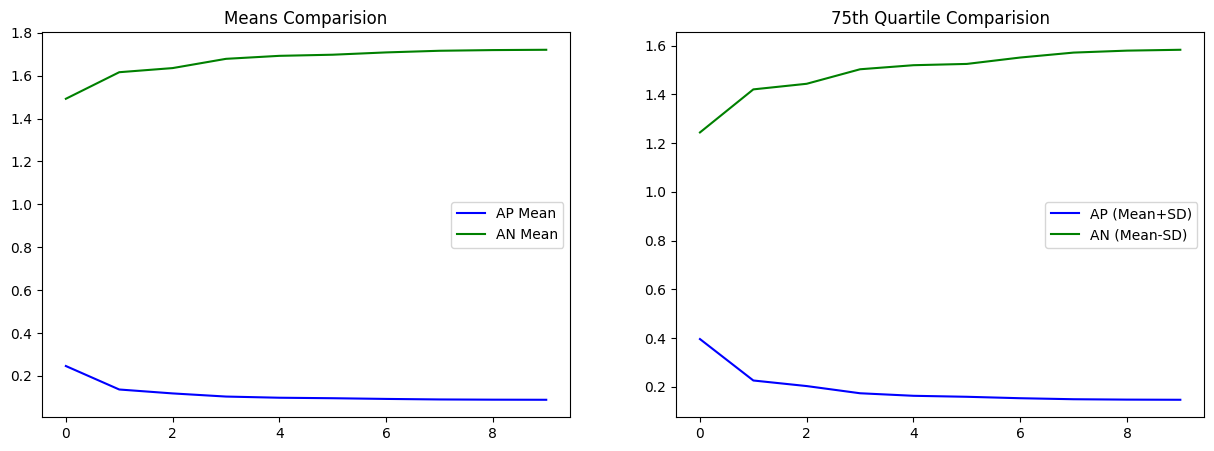

In [202]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]

    plt.figure(figsize=(15,5))

    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()

    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()

    plt.figure(figsize=(15,5))
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()

    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

In [203]:
def extract_encoder(model):
    encoder = get_encoder((224, 224, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_64 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 lambda_12 (Lambda)          (None, 256)               0         
                                                      

In [204]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

8/8 [==============================] - 1s 117ms/step

Accuracy of model: 0.98828125



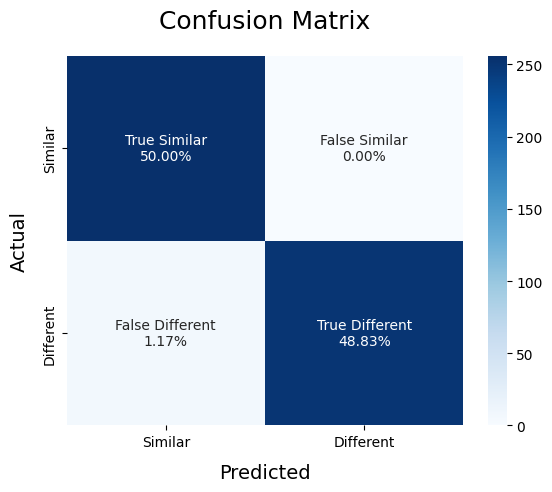

In [210]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])
anchors, positives, negatives = generate_triplets(test_dict, num_triplets=1000)
test_triplets = list(zip(anchors, positives, negatives))
for data in get_batch(test_triplets, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)